# README

In [1]:
README = '''
Julian Smoller ~ 2017.04.24

# Intro:
The purpose of this notebook is to load GPS data (created in a prior step) 
and render it in an image as colored squares, ellipses, and polygons. 

For example, I can draw the perimeter of Manhattan as a tan colored polygon, 
and I can draw Citibike stations as little blue squares. 

The code below relies on GPS data that was parsed and saved in a prior step. 
See the other notebook for how to parse and save KML data. 
At this point in the process, the GPS data is stored in dataframes that are saved as pickle files. 

This project was my first attempt to create a Citibike map using polygons. 
Later I learned how to use the Google maps API, which makes a lot more sense, 
but at least this code demonstrates how to draw polygons using the iDraw library. 

'''
print(README)


Julian Smoller ~ 2017.04.24

# Intro:
The purpose of this notebook is to load GPS data (created in a prior step) 
and render it in an image as colored squares, ellipses, and polygons. 

For example, I can draw the perimeter of Manhattan as a tan colored polygon, 
and I can draw Citibike stations as little blue squares. 

The code below relies on GPS data that was parsed and saved in a prior step. 
See the other notebook for how to parse and save KML data. 
At this point in the process, the GPS data is stored in dataframes that are saved as pickle files. 

This project was my first attempt to create a Citibike map using polygons. 
Later I learned how to use the Google maps API, which makes a lot more sense, 
but at least this code demonstrates how to draw polygons using the iDraw library. 




# Import libraries + change display settings

In [2]:
########################################################################
# Import libraries
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import numpy as np
import pickle
import pandas as pd

########################################################################
# Change display settings:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
%matplotlib inline

# Load GPS data

In [9]:
# Load GPS data for Manhattan perimeter, Manhattan parks, and Citibike locations (created earlier)
path_in = 'data/output/citibikes.p'
citibikes = pickle.load(open(path_in,'rb'))
citibikes.head(2)

,longitude,latitude,name,icon_shape,icon_color,description
0,-73.990662,40.771629,Bikes,1419,nodesc,
1,-73.988038,40.770499,Bikes,1419,nodesc,


In [10]:
path_in = 'data/output/parks.p'
parks = pickle.load(open(path_in,'rb'))
parks.head(2)

,coordinates,latitude,longitude,name
0,"-74.0188086,40.7081817,0.0 -74.018873,40.70800...","[40.708182, 40.708003, 40.7078, 40.7071, 40.70...","[-74.018809, -74.018873, -74.018219, -74.01854...",Polygon 1
1,"-74.0133905,40.7056849,0.0 -74.0138251,40.7051...","[40.705685, 40.705156, 40.70468, 40.70468, 40....","[-74.01339, -74.013825, -74.014083, -74.013342...",Polygon 2


In [11]:
path_in = 'data/output/perimeter.p'
perimeter = pickle.load(open(path_in,'rb'))
perimeter.head(2)

,latitude,longitude
0,40.701390,-74.015858
1,40.702871,-74.017307


# General functions

In [15]:
def get_box(point, radius):
    '''Given the xy coordinates of a point and a desired radius,
    return an array of two x,y points representing the top left and bottom right
    cornders of a box that contains the point and has desired radius;
    Example: get_box((0,0),1) >> [(-1,-1),(1,1)]'''
    # Top left; keep in mind that 0 is the highest y coordinate
    x_0 = point[0] - radius
    y_0 = point[1] - radius
    # Bottom right
    x_1 = point[0] + radius
    y_1 = point[1] + radius
    return [(x_0, y_0), (x_1, y_1)]

# Test
point = (0, 0)
radius = 1
get_box(point, radius)

[(-1, -1), (1, 1)]

In [16]:
# General function to display images 
def show(im):
    return imshow(np.asarray(im))

# MapMaker

pixels_per_degree 5543.390892208764


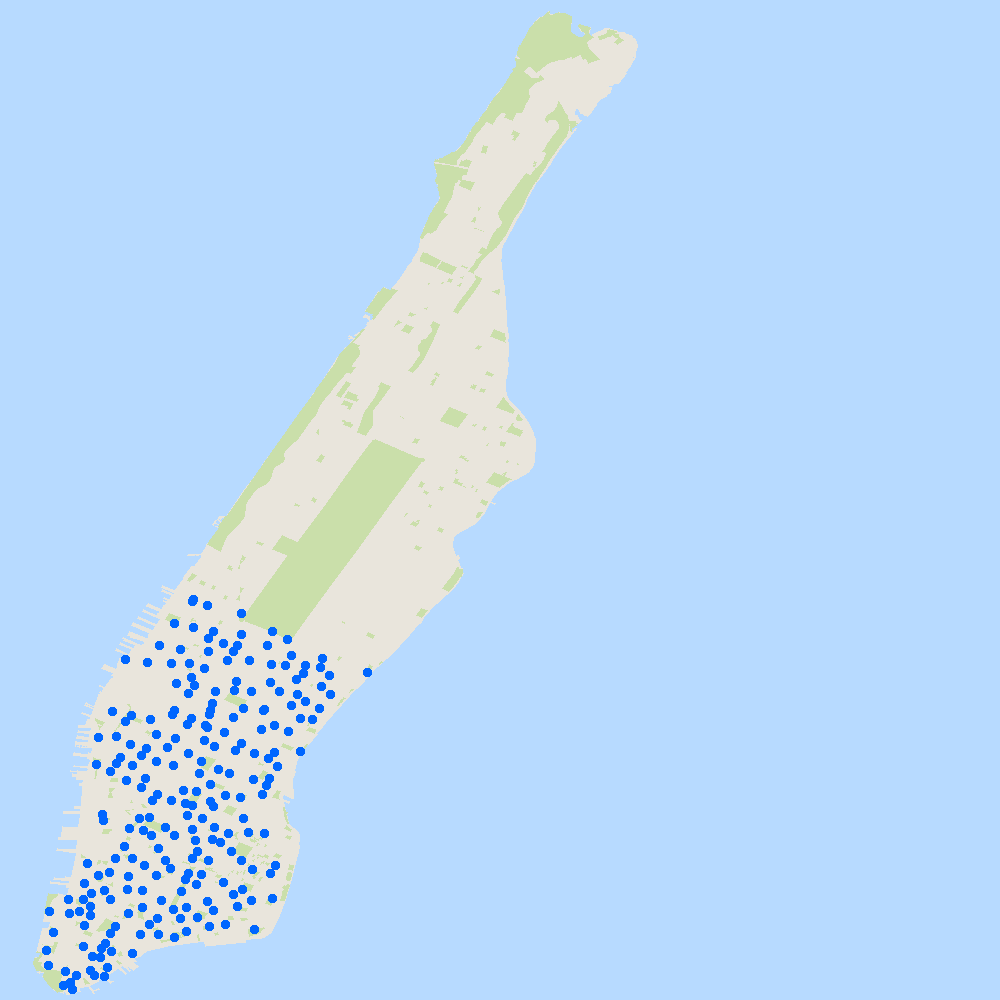

In [23]:
class MapMaker: 
    '''A MapMaker will accept GPS data representing land, parks, and points of interest,
    e.g. Citibike stations, as well as a set of desired colors. It will then render an image
    representing a map of the land and points of interest, with GPS coordinates translated
    to pixel coordinates.'''
    def __init__(self,gps_corners,xy_corners,colors):
        self.set_gps_corners(gps_corners)
        self.set_xy_corners(xy_corners)
        self.set_pixels_per_degree()
        self.colors = colors
        self.data = {'land':[],'parks':[],'points':[]}
    def set_gps_corners(self,gps_corners):
        self.lon0 = gps_corners[0]
        self.lat0 = gps_corners[1]
        self.lon1 = gps_corners[2]
        self.lat1 = gps_corners[3]
        # Calculate longitude / latitude dimensions
        self.lon_span = round(self.lon1 - self.lon0, 6)
        self.lat_span = round(self.lat1 - self.lat0, 6)
    def set_xy_corners(self,xy_corners):
        self.x0 = xy_corners[0]
        self.y0 = xy_corners[1]
        self.x1 = xy_corners[2]
        self.y1 = xy_corners[3]
        # Calculate x and y dimensions (width, height)
        self.x_span = self.x1 - self.x0
        self.y_span = self.y1 - self.y0
    def set_pixels_per_degree(self):
        '''The conversion factor should be set so that the largest dimension (geographically) 
        will fit into the allocated number of pixels'''
        self.pixels_per_degree = min((self.x_span/self.lon_span),(self.y_span/self.lat_span))
    def longitude_to_x(self,longitude):
        return int((longitude - self.lon0)*self.pixels_per_degree)
    def latitude_to_y(self,latitude):
        return self.y1 - int((latitude - self.lat0)*self.pixels_per_degree)
    def get_xy_for_gps_data(self,d):
        '''Given a dictionary with longitude and latitude arrays, return a list of xy tuples'''
        xy = []
        for i in range(len(d['longitude'])):
            xy.append((self.longitude_to_x(d['longitude'][i]), self.latitude_to_y(d['latitude'][i])))
        return xy
    def draw(self):
        # Create RGB image with water-colored background
        self.im = Image.new('RGB', (self.x_span,self.y_span), self.colors['water'])
        # Create iDraw object for drawing polygons
        self.idraw = ImageDraw.Draw(self.im)
        # Draw land: Manhattan
        self.draw_land()
        # Draw parks
        self.draw_parks()
        # Draw points: Citibike stations
        self.draw_points()
        return self.im
    def draw_land(self):
        # Draw polygon to represent land
        land_xy = self.get_xy_for_gps_data(self.data['land'])
        land_color = self.colors['land']
        self.idraw.polygon(land_xy, fill=land_color, outline=None)
    def draw_parks(self):
        # Draw polygons to represent the parks
        for i in self.data['parks'].index:
            park_xy = self.get_xy_for_gps_data(self.data['parks'].ix[i])
            park_color = self.colors['park']
            self.idraw.polygon(park_xy, fill=park_color, outline=None)
    def draw_points(self):
        # Draw points: Citibike stations
        for i in self.data['points'].index:
            x = self.longitude_to_x(self.data['points'].ix[i,'longitude'])
            y = self.latitude_to_y(self.data['points'].ix[i,'latitude'])
            # Draw elippse centered at Citibike location
            box = get_box((x,y), 4)
            self.idraw.ellipse(box, fill=colors['point'], outline=None)

# These coordinates define the boundaries of the geographic map 
longitude_0 = -74.025491
longitude_1 = -73.898805
latitude_0 = 40.699240
latitude_1 = 40.879635
gps_corners = (longitude_0,latitude_0,longitude_1,latitude_1)

# These coordinates define the pixel dimensions of the image
x_0 = 0
y_0 = 0
x_1 = 1000
y_1 = 1000
xy_corners = (x_0,y_0,x_1,y_1)

# These are the RGB colors to use for different objects on the map
colors = {}
colors['land'] = (233,229,220) #E9E5DC 
colors['park'] = (202,223,170) #CADFAA
colors['water'] = (183, 218, 255) #B7DAFF
colors['point'] = (0, 102, 255) # Blue, for Citibike stations

mm = MapMaker(gps_corners,xy_corners,colors)
mm.data['land'] = perimeter
mm.data['parks'] = parks
mm.data['points'] = citibikes
print('pixels_per_degree',mm.pixels_per_degree)
mm.draw()